In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle

plt.style.use('article.mplstyle')

# Optimal reflection search

Maximum reflection coefficient: 0.5712 at detuning: 0.0778 Γ


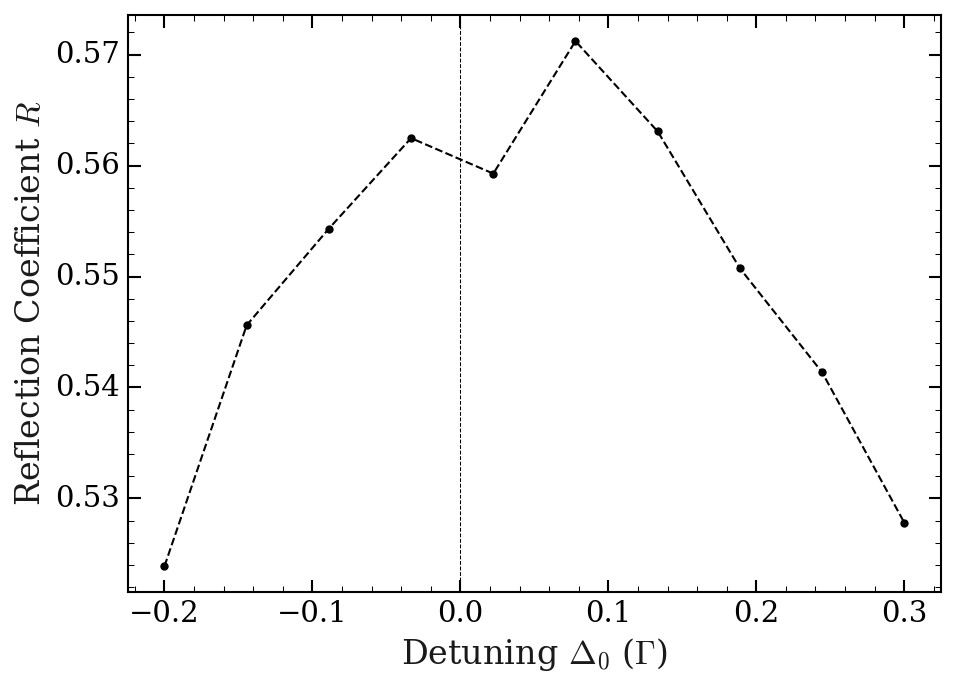

In [19]:
delta = np.loadtxt("data/ReflectionCoefficient-3/delta-local.txt")
R = np.loadtxt("data/ReflectionCoefficient-3/intensity-local.txt")

max_idx = np.argmax(R)
max_R = R[max_idx]
max_delta = delta[max_idx]

print(f"Maximum reflection coefficient: {max_R:.4f} at detuning: {max_delta:.4f} Γ")

plt.plot(delta, R, 'o--', markersize=4, color='black')
plt.xlabel(r"Detuning $\Delta_0$ ($\Gamma$)")
plt.ylabel(r"Reflection Coefficient $R$")
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.5)
plt.savefig("fig/detuning_search.svg", bbox_inches='tight')
plt.show()

# 2D Stationnary Intensity Plot

In [9]:
X = np.loadtxt("data/2DStationnary-1/X-local.txt", delimiter=",")
Z = np.loadtxt("data/2DStationnary-1/Z-local.txt", delimiter=",")
intensity = np.loadtxt("data/2DStationnary-1/intensity-local.txt", delimiter=",")

def show_intensity_xOz(I, x, z, scatterers,  *arrow_directions, cmap='binary'):
    x_max = np.max(scatterers[:, 0])
    x_min = np.min(scatterers[:, 0])
    z_max = np.max(scatterers[:, 2])
    z_min = np.min(scatterers[:, 2])

    fig = plt.figure()
    ax = fig.add_subplot()

    surface = ax.pcolormesh(z, x, I, cmap=cmap, norm=LogNorm(vmin=np.min(I), vmax=np.max(I)), shading='gouraud')
    cbar = fig.colorbar(surface, ax=ax)
    cbar.set_label("$(|E|/E_0)^2$")

    rect = Rectangle((z_min, x_min), width=z_max-z_min, height=x_max-x_min, linewidth=1.5, linestyle='--',
                     edgecolor='black', facecolor='none')
    ax.add_patch(rect)

    for direction in arrow_directions:
        plt.quiver(0, 0, direction[2], direction[0], angles='xy', scale=8)

    plt.xlabel('$z ~ (\\lambda)$')
    plt.ylabel("$x ~ (\\lambda)$")
    ax.set_title(f"Stationnary intensity in the $xOz$ plane\n")

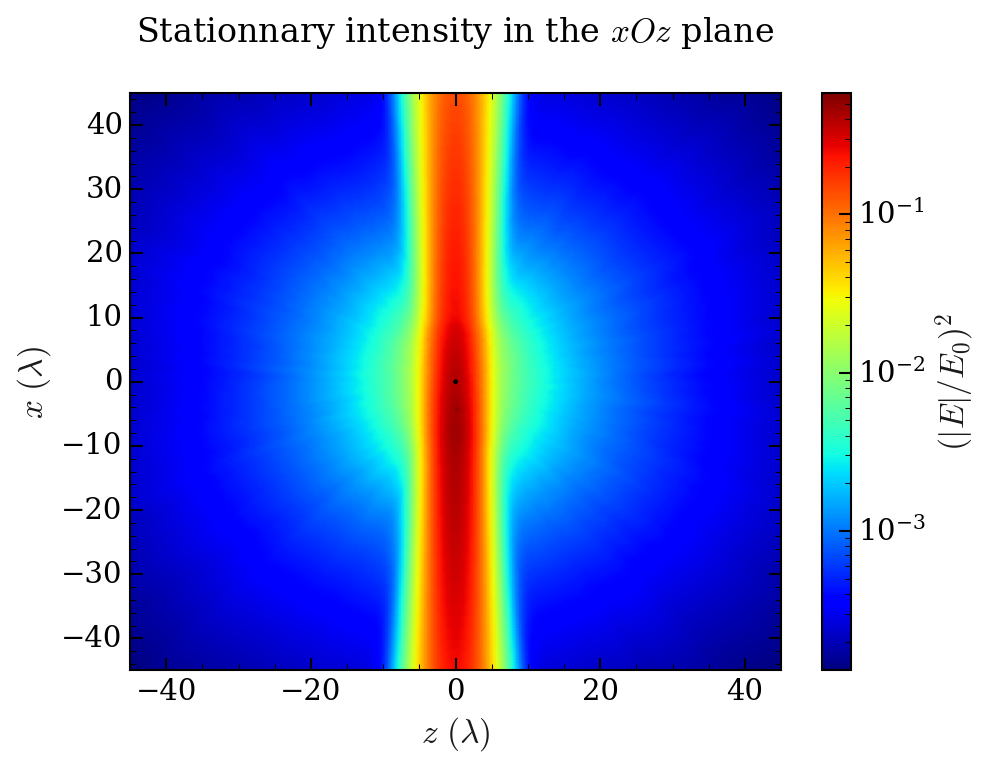

In [10]:
show_intensity_xOz(intensity, X, Z, X, [0, 0, 0], [0, 0, 0], cmap='jet')
plt.show()

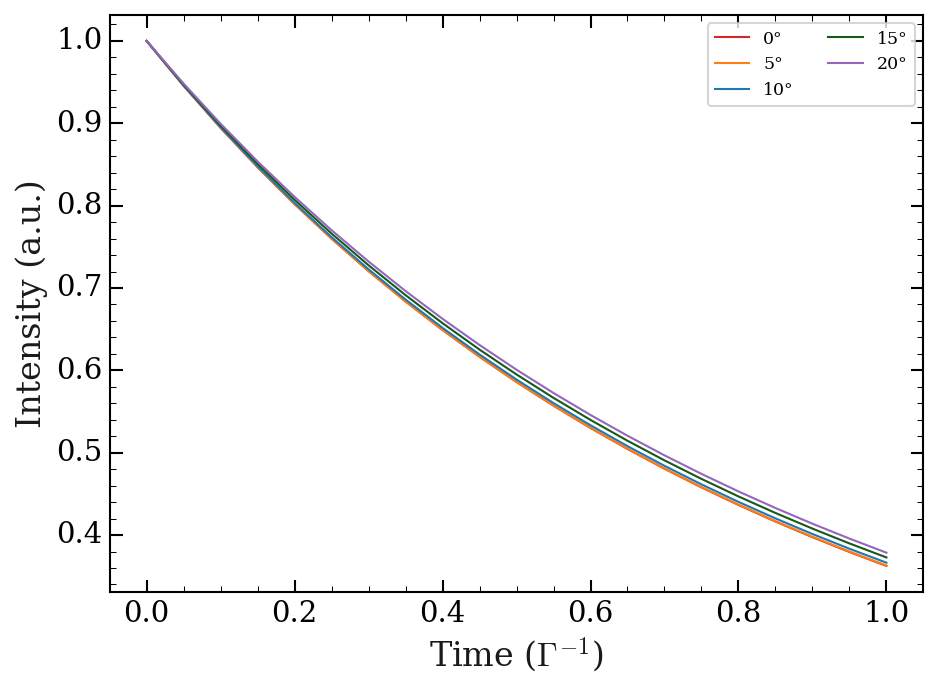

In [10]:
JOBID=22083
I1 = np.loadtxt(f"data/Dynamic/intensity-{JOBID}.csv", delimiter=",")
I2 = np.loadtxt(f"data/Dynamic/intensity-{JOBID+1}.csv", delimiter=",")
I3 = np.loadtxt(f"data/Dynamic/intensity-{JOBID+2}.csv", delimiter=",")
I = (I1 + I2 + I3) / 3
t = np.loadtxt(f"data/Dynamic/time-{JOBID}.txt", delimiter=",")

for i in range(I.shape[0]):
    plt.plot(t, I[i, :], label=f"{5*i}°")

plt.xlabel("Time ($\\Gamma^{-1}$)")
plt.ylabel("Intensity (a.u.)")
plt.legend(loc='upper right', ncol=2, fontsize='small')
plt.show()